# AMATH 482 Homework 4 - *Classifying Politicians*

## Lang Qin

# Environment Setup

We first connect our notebook to personal google drive.

In [1]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Mounted at /content/drive


Then, we read in the given the dataset. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

path_to_data = '/content/drive/My Drive/AMATH 482/HW4/house-votes-84.data'

df = np.loadtxt(path_to_data, delimiter = ',', dtype =object)

# Data Preprocessing

Construct the output vector $y$ by assigning labels $\{-1, 1\}$ to members of different parties.

Construct the input vectors $x_j$ corresponding to the voting records of each member by replacing $'y'$ votes with $+1$, $'n'$ votes with $-1$ and '?' with 0.

This step gives a vector $\mathbf{y}\in\mathbb{R}^{435}$ and input matrix $\mathbf{X}\in\mathbb{R}^{435×16}$, where $\mathbf{X}$ conforms `sklearn` convention. 

In [5]:
# initialize storages for x and y
x_shape = (df.shape[0], df.shape[1]-1)
x = np.zeros(x_shape)
y = []

# generate x and y
row_count = 0

for votes in df:
    for i in range(len(votes)):
        # assign y
        if votes[i] == 'republican':
            y.append(1)
        elif votes[i] == 'democrat':
            y.append(-1)
        # assign x
        if votes[i] == 'n':
            x[row_count ,i-1] = -1
        elif votes[i] == 'y':
            x[row_count, i-1] = 1
        else:
            x[row_count, i-1] = 0

    row_count += 1
    
y = np.asarray(y)

In [6]:
print("X shape: ", x.shape)
print("y shape: ", y.shape)

X shape:  (435, 16)
y shape:  (435,)


# Spectral Clustering

## Unnormalized graph Laplacian matrix on $\mathbf{X}$



Construct the unnormalized graph Laplacian matrix on 𝑋 using the weight function
$$
\eta(t) = \exp{\left(-\frac{t^2}{2\sigma^2}\right)}
$$
with variance parameter $\sigma$ and compute its second eigenvector (i.e., the Fiedler vector) which we
denote as $\mathbf{q}_1$.

Take $\mathbf{q}_1$ as the classifier and compute the classification accuracy.

In [7]:
# weight function
def eta(t, r):
    val = np.exp(-(t**2)/(2*r**2)) 
    return val.astype(float)

In [12]:
import scipy.spatial

dist = scipy.spatial.distance_matrix(x, x, p=2)
error = []

sigmas = np.arange(0.1, 4, 0.01)
for sigma in sigmas:
    W = eta(dist, sigma)
    D = np.diag(np.sum(W, axis=1))

    # eigen decomposition 
    values, vectors = np.linalg.eigh(D - W)

    # sort the eigenvalues and vectors 
    idx = values.argsort()
    vectors = vectors[:, idx]

    # extract the second eigenvector
    q1 = vectors[:, 1]
    
    # compute classificiation accuracy
    y_pred = []

    # adjust the prediction
    for element in q1:
        if element < 0:
            y_pred.append(-1)
        else:
            y_pred.append(1)

    y_pred = np.asarray(y_pred)

    # feature misclassified results
    curr_error = 1 - np.count_nonzero(y_pred == y)/435

    # compute errors
    if curr_error < 0.5:
        error.append(curr_error)
    elif curr_error > 0.5:
        error.append(1 - curr_error)

error = np.asarray(error)
cluster_accuracy = 1 - error

Extract $\sigma^*$, the optimal variance parameter achieving maximum clustring accuracy.

In [13]:
# indicies associated with the maximum accuracy
idx = np.array(np.where(cluster_accuracy==cluster_accuracy.max()), dtype=int)

# extract sigmas at the indcies 
sigmas[idx]

array([[1.17, 1.47, 1.48, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39,
        3.4 , 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 ,
        3.51, 3.52, 3.53]])

In [14]:
# check the errors at the above indcies
error[idx]

array([[0.11954023, 0.11954023, 0.11954023, 0.11954023, 0.11954023,
        0.11954023, 0.11954023, 0.11954023, 0.11954023, 0.11954023,
        0.11954023, 0.11954023, 0.11954023, 0.11954023, 0.11954023,
        0.11954023, 0.11954023, 0.11954023, 0.11954023, 0.11954023,
        0.11954023, 0.11954023, 0.11954023, 0.11954023, 0.11954023]])

## Accuracy function plot

Plot accuracy as a function of $\sigma$.

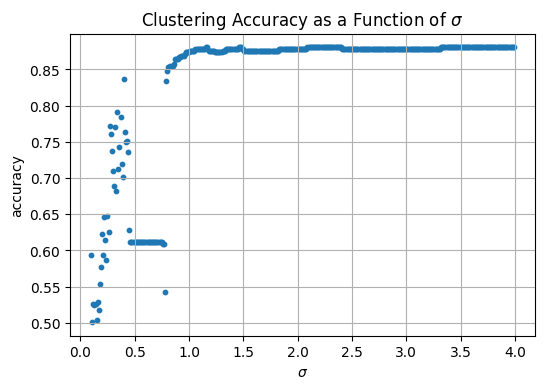

In [15]:
fig = plt.figure(dpi = 100)
ax = plt.axes()

ax.scatter(sigmas, cluster_accuracy, s=10)
ax.set_title("Clustering Accuracy as a Function of $\sigma$")
ax.set_xlabel("$\sigma$")
_ = ax.set_ylabel("accuracy")
ax.grid()

Here, we pick 1.17 as our $\sigma^*$.


# Semi-supervised Learning

In [16]:
# initialize M and J
M = [2,3,4,5,6]
J = [5,10,20,40]

## Find the optimal parameter $M^*$ and $J^*$. 

In [17]:
from sklearn.linear_model import Ridge

# optimal sigma obtained in previous section
sigma_opt = 1.17

# construct Laplacian matrix
dist = scipy.spatial.distance_matrix(x, x, p=2)       
W = eta(dist, sigma_opt)
D = np.diag(np.sum(W, axis=1))
# x = np.zeros(x_shape) has been defined in previous seciton

# compute eigendecompositions 
values, vectors = np.linalg.eigh(D - W)

# sort the eigenvalues and vectors 
idx = values.argsort()
vector = vectors[:, idx]

error_ss = np.zeros([len(J), len(M)])
row = 0
col = 0
for j in J:
    for m in M:
        curr = vectors[0:j, 0:m]

        # develop the linear model
        model = Ridge(alpha = 0, fit_intercept=False)
        model.fit(curr, y[0:j])

        curr_pred =  np.dot(vector[:,0:m], model.coef_)
        
        # adjust the predictions
        curr_pred_adjusted = []
        for element in curr_pred:
            curr_pred_adjusted.append(-1) if element < 0 else curr_pred_adjusted.append(1)
        
        curr_pred_adjusted = np.asarray(curr_pred_adjusted)

        # compute SSL adjusted errors
        curr_error = 1 - np.count_nonzero(curr_pred_adjusted == y)/435
        error_ss[row, col] = (curr_error)
        col += 1

    col = 0
    row += 1

# compute accuracy from error
accuracy_ss = 1 - error_ss

In [18]:
# preview the adjusted SSL accuarcy
print(accuracy_ss)

# extract the highest accuracy
accuracy_ss_max = np.max(accuracy_ss)
print("Maximum accuracy: ", accuracy_ss_max)

# determine the optiaml parameter M* and J*
np.array(np.where(accuracy_ss == accuracy_ss_max), dtype=int)

[[0.88965517 0.88735632 0.84137931 0.86896552 0.86896552]
 [0.88735632 0.81609195 0.85057471 0.70114943 0.68965517]
 [0.88275862 0.82298851 0.86436782 0.84137931 0.87586207]
 [0.88045977 0.83908046 0.87586207 0.88045977 0.86436782]]
Maximum accuracy:  0.8896551724137931


array([[0],
       [0]])

Thus, we choose $M^*=2$ and $J^*=5$ as the optimal parameters.

## Behavior plot of optimal $F(X)\hat{β}$

In [19]:
# compute the result at optimality
model = Ridge(alpha = 0, fit_intercept=False)
model.fit(vectors[0:5, 0:2], y[0:5])

pred = np.dot(vector[:,0:2], model.coef_)

pred_adjusted = []
for element in pred:
    pred_adjusted.append(-1) if element < 0 else pred_adjusted.append(1)

Text(0, 0.5, 'index')

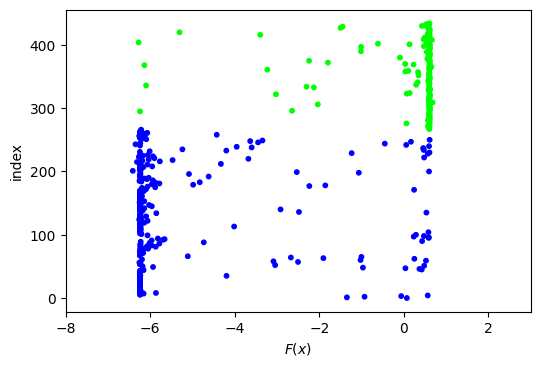

In [20]:
# plot
Y = np.zeros((y.shape[0]))
F = np.zeros((y.shape[0]))

idx_demo = np.array(np.where(y==y.min()), dtype=int).T
count_demo = idx_demo.shape[0]

F[0:count_demo] = pred[idx_demo.flatten()]
Y[0:count_demo] = y[idx_demo.flatten()]

idx_re = np.array(np.where(y == y.max()), dtype=int).T
count_re = idx_re.shape[0]

F[count_demo : count_demo+count_re] = pred[idx_re.flatten()]
Y[count_demo : count_demo+count_re] = y[idx_re.flatten()]

fig = plt.figure(dpi = 100)
ax = plt.axes()
ax.scatter(F, np.arange(count_demo + count_re), c=Y, s=10, cmap='brg')
ax.set_xlabel('$F(x)\beta$')
ax.set_xlim(-8, 3)
ax.set_ylabel("index")

## Behavior plot of optimal classifier

(0.96, 1.04)

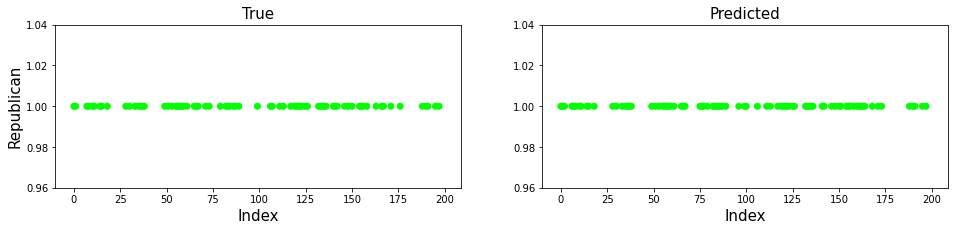

In [21]:
# plot for republican
fig, ax = plt.subplots(1, 2, figsize=(16, 3))

ax[0].scatter(np.arange(200), y[:200], c=y[:200], cmap='brg')
ax[0].set_xlabel('Index', fontsize=15)
ax[0].set_ylabel('Republican', fontsize=15)
ax[0].set_title('True', fontsize=15)
ax[0].set_ylim(0.96, 1.04)

ax[1].scatter(np.arange(200), pred_adjusted[:200], c=pred_adjusted[:200], cmap='brg')
ax[1].set_xlabel('Index', fontsize=15)
ax[1].set_title('Predicted', fontsize=15)
ax[1].set_ylim(0.96, 1.04)

(-0.96, -1.04)

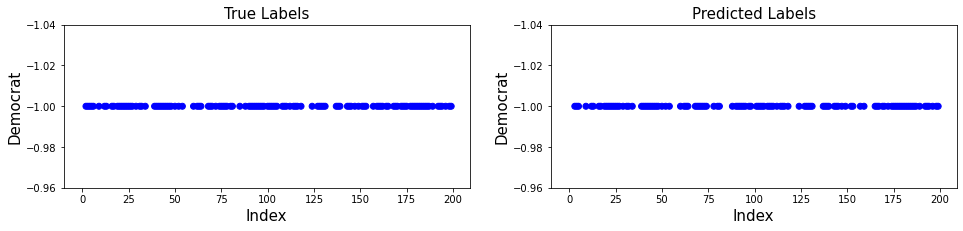

In [22]:
# plot for democrat
fig, ax = plt.subplots(1, 2, figsize=(16, 3))

ax[0].scatter(np.arange(200), y[:200], c=y[:200], cmap='brg')
ax[0].set_xlabel('Index', fontsize=15)
ax[0].set_ylabel('Democrat', fontsize=15)
ax[0].set_title('True Labels', fontsize=15)
ax[0].set_ylim(-0.96,-1.04)

ax[1].scatter(np.arange(200), pred_adjusted[:200], c=pred_adjusted[:200], cmap='brg')
ax[1].set_xlabel('Index', fontsize=15)
ax[1].set_ylabel('Democrat', fontsize=15)
ax[1].set_title('Predicted Labels', fontsize=15)
ax[1].set_ylim(-0.96,-1.04)